In [1]:
import sys
import sklearn
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np

import plotly.graph_objs as go
from plotly.offline import iplot
from matplotlib import pyplot as plt

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)


In [4]:
## Data Visualization

import os

def get_data():
    return pd.read_csv('metadata.csv/metadata.csv')

meta = get_data()
meta.head()


,videoname,original_width,original_height,label,original
0,aznyksihgl.mp4,129,129,FAKE,xnojggkrxt.mp4
1,gkwmalrvcj.mp4,129,129,FAKE,hqqmtxvbjj.mp4
2,lxnqzocgaq.mp4,223,217,FAKE,xjzkfqddyk.mp4
3,itsbtrrelv.mp4,186,186,FAKE,kqvepwqxfe.mp4
4,ddvgrczjno.mp4,155,155,FAKE,pluadmqqta.mp4


In [5]:
meta.shape


(95634, 5)

In [6]:
len(meta[meta.label == 'FAKE']), len(meta[meta.label == 'REAL'])


(79341, 16293)

In [7]:
real_df = meta[meta["label"] == "REAL"]
fake_df = meta[meta["label"] == "FAKE"]
sample_size = 8000

real_df = real_df.sample(sample_size, random_state=42)
fake_df = fake_df.sample(sample_size, random_state=42)

sample_meta = pd.concat([real_df, fake_df])


In [8]:
from sklearn.model_selection import train_test_split

Train_set, Test_set = train_test_split(sample_meta, test_size=0.2, random_state=42, stratify=sample_meta['label'])
Train_set, Val_set = train_test_split(Train_set, test_size=0.3, random_state=42, stratify=Train_set['label'])


In [9]:
Train_set.shape, Val_set.shape, Test_set.shape


((8960, 5), (3840, 5), (3200, 5))

In [10]:
y = dict()

y[0] = []
y[1] = []

for set_name in (np.array(Train_set['label']), np.array(Val_set['label']), np.array(Test_set['label'])):
    y[0].append(np.sum(set_name == 'REAL'))
    y[1].append(np.sum(set_name == 'FAKE'))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='REAL',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='FAKE',
    marker=dict(color='#ff3300'),
    opacity=0.7
)

data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)

fig = go.Figure(data, layout)
iplot(fig)


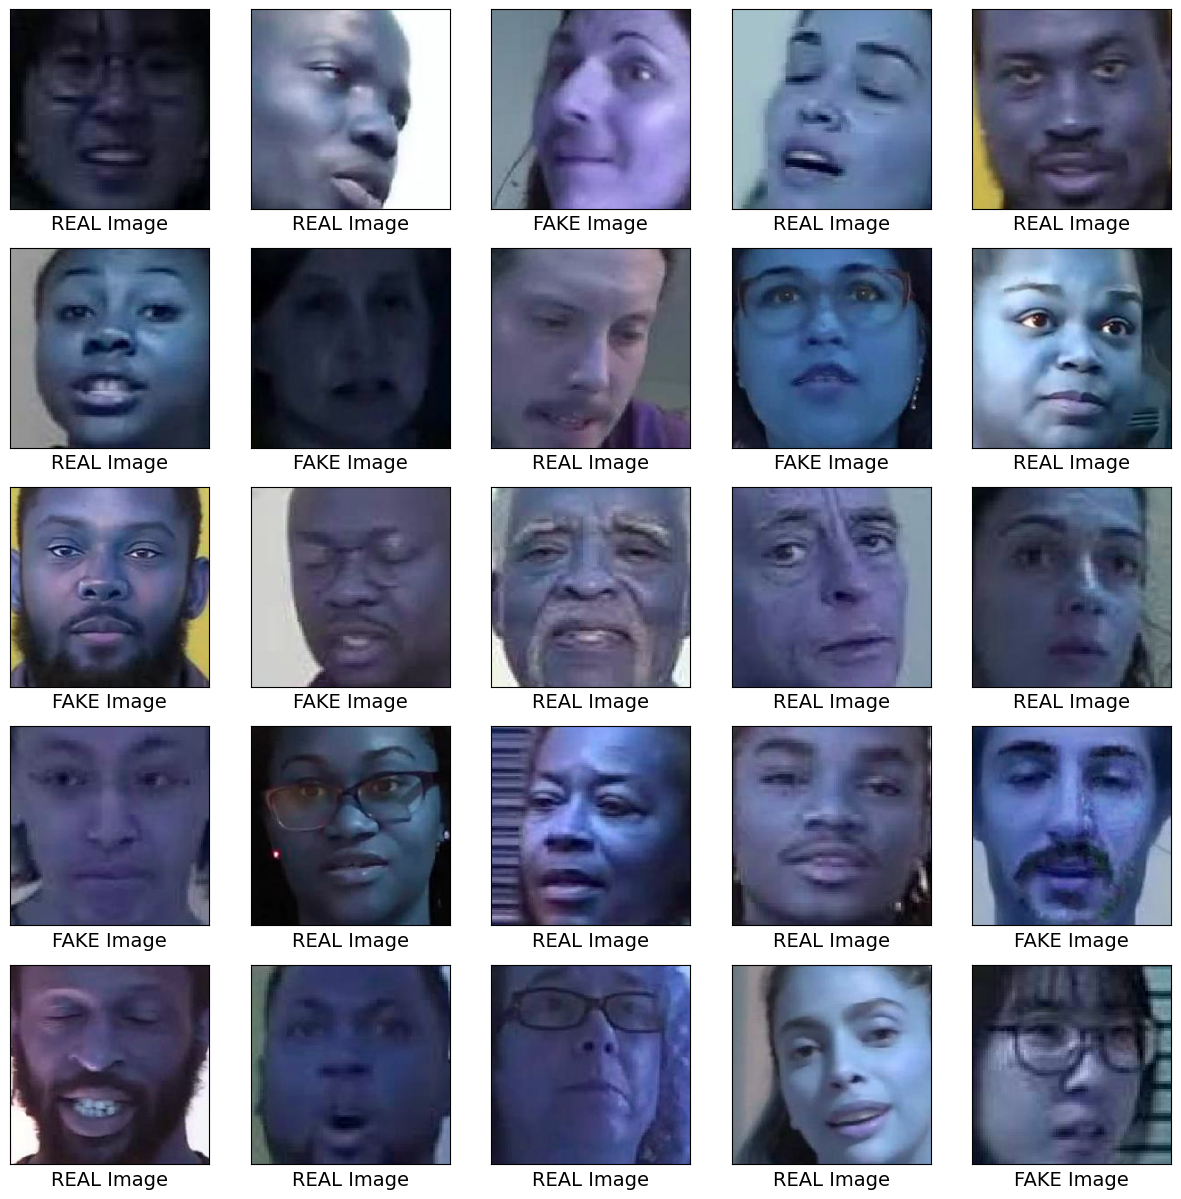

In [11]:
plt.figure(figsize=(15, 15))
for cur, i in enumerate(Train_set.index[25:50]):
    plt.subplot(5, 5, cur + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    plt.imshow(cv2.imread('faces_224/' + Train_set.loc[i, 'videoname'][:-4] + '.jpg'))
    
    if Train_set.loc[i, 'label'] == 'FAKE':
        plt.xlabel('FAKE Image')
    else:
        plt.xlabel('REAL Image')

plt.show()


In [13]:
def retrieve_dataset(set_name):
    images, labels = [], []
    for (img, imclass) in zip(set_name['videoname'], set_name['label']):
        images.append(cv2.imread('faces_224/' + img[:-4] + '.jpg'))
        if imclass == 'FAKE':
            labels.append(1)
        else:
            labels.append(0)

    return np.array(images), np.array(labels)


In [14]:

X_train, y_train = retrieve_dataset(Train_set)


In [15]:
X_val, y_val = retrieve_dataset(Val_set)


In [16]:
X_test, y_test = retrieve_dataset(Test_set)


In [17]:
from functools import partial

tf.random.set_seed(42) 

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")

model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[224, 224, 3]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 401408)            0

Epoch 1/5
560/560 [==============================] - 65s 96ms/step - loss: 22.6458 - accuracy: 0.5023 - val_loss: 0.6942 - val_accuracy: 0.4924
Epoch 2/5
560/560 [==============================] - 53s 95ms/step - loss: 0.8810 - accuracy: 0.5038 - val_loss: 0.6936 - val_accuracy: 0.4977
Epoch 3/5
560/560 [==============================] - 51s 91ms/step - loss: 0.6938 - accuracy: 0.5066 - val_loss: 0.6934 - val_accuracy: 0.4990
Epoch 4/5
560/560 [==============================] - 52s 92ms/step - loss: 0.6987 - accuracy: 0.4984 - val_loss: 0.6932 - val_accuracy: 0.4992
Epoch 5/5
100/100 [==============================] - 5s 38ms/step - loss: 0.6942 - accuracy: 0.5128


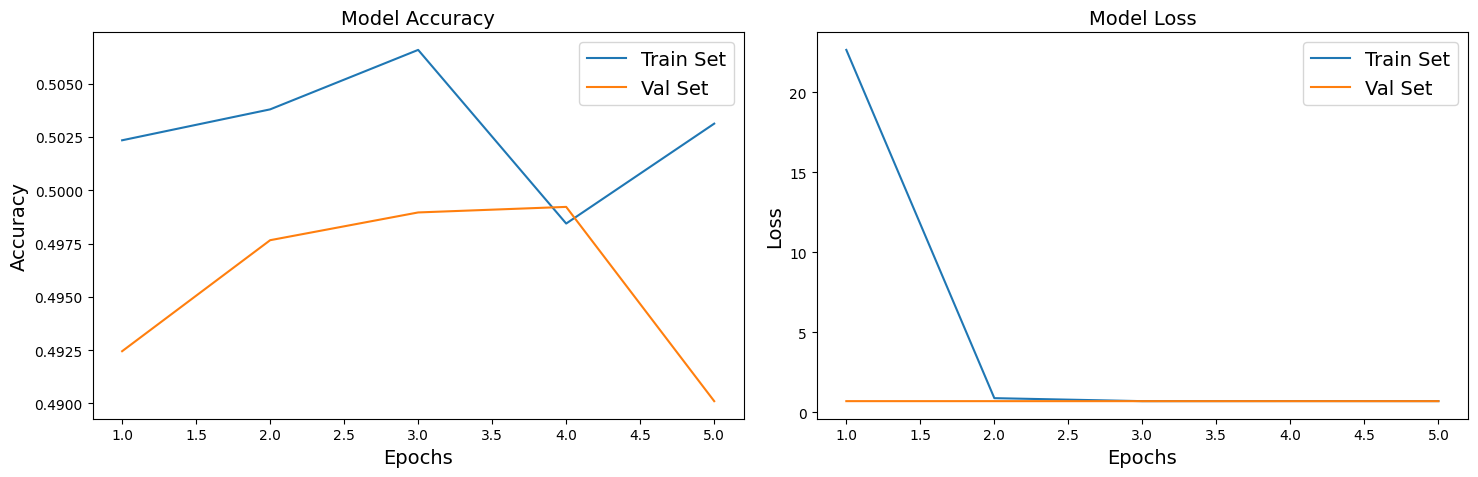

In [18]:
history = model.fit(X_train, y_train, epochs=5, batch_size=16, validation_data=(X_val, y_val))

# Evaluate the model on the test set
score = model.evaluate(X_test, y_test)

# Plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()


In [19]:
# Replace Xception with InceptionResNetV2
base_model = tf.keras.applications.InceptionResNetV2(weights="imagenet", include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(1, activation="sigmoid")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Train for a few epochs with frozen base model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3)

# Evaluate the model on the test set
score = model.evaluate(X_test, y_test)

# Print the layers of InceptionResNetV2
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()


219055592/219055592 [==============================] - 119s 1us/step
Epoch 1/3
280/280 [==============================] - 73s 228ms/step - loss: 1385606.8750 - accuracy: 0.5041 - val_loss: 106848.3672 - val_accuracy: 0.5148
Epoch 2/3
280/280 [==============================] - 63s 224ms/step - loss: 1048454.7500 - accuracy: 0.5070 - val_loss: 1426630.8750 - val_accuracy: 0.5000
Epoch 3/3
100/100 [==============================] - 17s 167ms/step - loss: 2318175.2500 - accuracy: 0.5000
  0: input_1                33: batch_normalization_7  66: conv2d_22              99: batch_normalization_29
  1: conv2d_3               34: batch_normalization_10 67: conv2d_25             100: activation_24         
  2: batch_normalization    35: batch_normalization_11 68: batch_normalization_19101: activation_26         
  3: activation             36: activation_5           69: batch_normalization_22102: activation_29         
  4: conv2d_4               37: activation_7           70: activation_19    

Epoch 1/10
280/280 [==============================] - 103s 326ms/step - loss: 120.2367 - accuracy: 0.5391 - val_loss: 17.6167 - val_accuracy: 0.5305
Epoch 2/10
280/280 [==============================] - 86s 309ms/step - loss: 6.3657 - accuracy: 0.5310 - val_loss: 6.6425 - val_accuracy: 0.5562
Epoch 3/10
280/280 [==============================] - 88s 313ms/step - loss: 4.1664 - accuracy: 0.5366 - val_loss: 2.6187 - val_accuracy: 0.5531
Epoch 4/10
280/280 [==============================] - 98s 351ms/step - loss: 2.8808 - accuracy: 0.5421 - val_loss: 3.1615 - val_accuracy: 0.5599
Epoch 5/10
280/280 [==============================] - 114s 407ms/step - loss: 2.3564 - accuracy: 0.5516 - val_loss: 1.5808 - val_accuracy: 0.5367
Epoch 6/10
280/280 [==============================] - 131s 468ms/step - loss: 1.8014 - accuracy: 0.5501 - val_loss: 2.1587 - val_accuracy: 0.5245
Epoch 7/10
280/280 [==============================] - 137s 491ms/step - loss: 1.5271 - accuracy: 0.5682 - val_loss: 2.1323 -

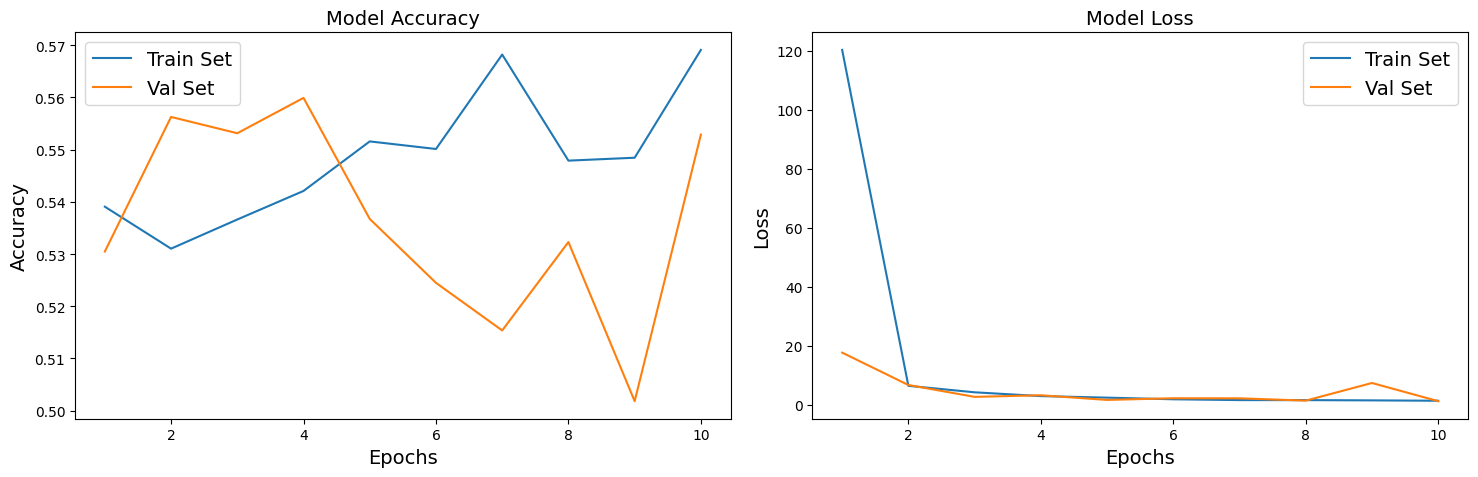

100/100 [==============================] - 17s 166ms/step - loss: 1.3529 - accuracy: 0.5544


In [20]:
# Make top layers trainable again
for layer in base_model.layers[56:]:
    layer.trainable = True

# Compile the model with a lower learning rate
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Continue training
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

# Plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

# Evaluate the model on the test set
model.evaluate(X_test, y_test)

# Save the model
model.save('inceptionresnetv2_deepfake_image.h5')


100/100 [==============================] - 25s 190ms/step - loss: 1.3529 - accuracy: 0.5544


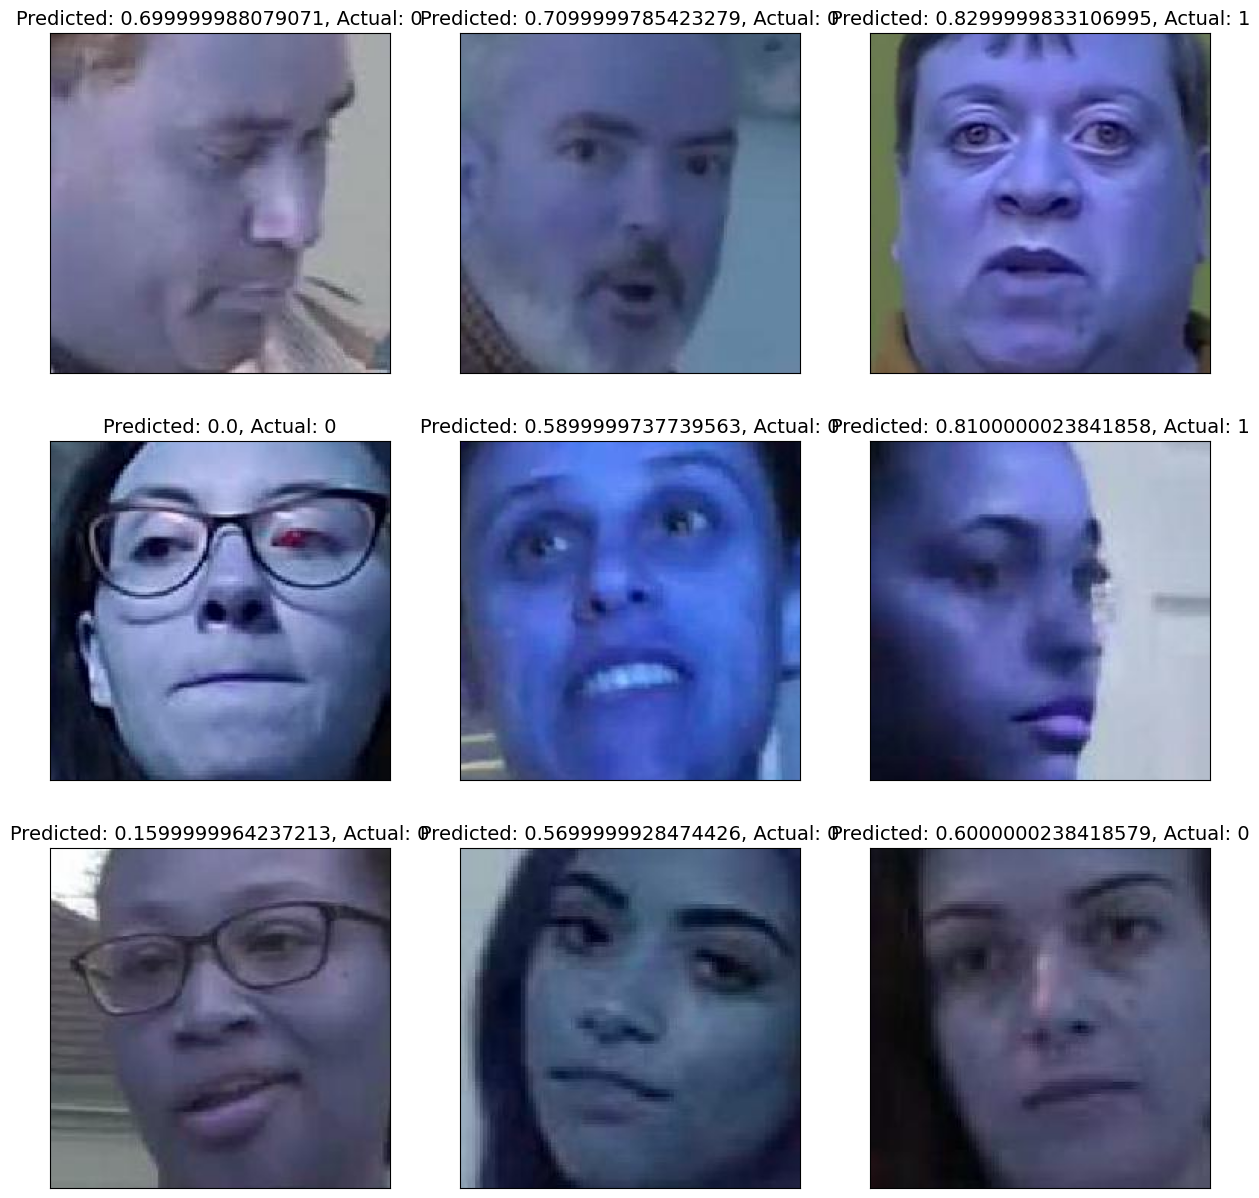

In [21]:
# Load the saved model
loaded_model = tf.keras.models.load_model('inceptionresnetv2_deepfake_image.h5')

# Make predictions on a sample test set
predictions = loaded_model.predict(X_test)

# Evaluate the loaded model
loaded_model.evaluate(X_test, y_test)

# Visualize a few predictions
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(X_test[i])
    plt.title(f"Predicted: {round(predictions[i][0], 2)}, Actual: {y_test[i]}")

plt.show()


100/100 [==============================] - 14s 144ms/step


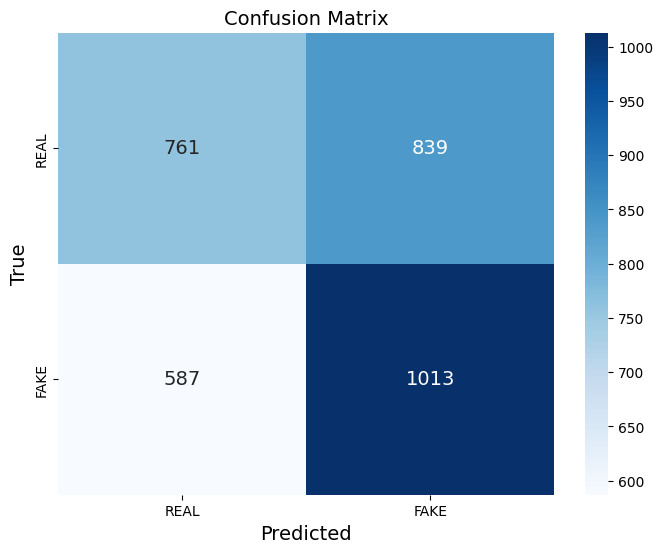

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.48      0.52      1600
           1       0.55      0.63      0.59      1600

    accuracy                           0.55      3200
   macro avg       0.56      0.55      0.55      3200
weighted avg       0.56      0.55      0.55      3200



In [23]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Make predictions using the loaded model
predictions = loaded_model.predict(X_test)

# Convert predictions to binary values (0 or 1) based on a threshold (e.g., 0.5)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['REAL', 'FAKE'],
            yticklabels=['REAL', 'FAKE'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Display the classification report
print("Classification Report:\n", classification_report(y_test, binary_predictions))
